In [1]:
import csv
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import japanize_matplotlib
import seaborn as sns
import os
from tqdm import tqdm

sns.set()
sns.set(font="IPAexGothic")
from one_pig_graph import df_filter, save_histgram, save_histgram_movie

base_data_dir = "/workspace/mass/ecopork-main/output/one_pig_tracking_result"
dir_list = os.listdir(base_data_dir)


In [2]:
def run(pig_id, csv_path, output_path, movie_path, eval_type):

    df = pd.read_csv(csv_path)
    df = df_filter(df, eval_type)
    save_histgram(df, output_path)
    # save_histgram_movie(df, movie_path)

    mean = df["pred"].mean()
    print(pig_id + "平均値:" + str(mean))

    # rate = len(df[df[''] == '<4%']) / (len(df[df[''] == '<4%']) + len(df[df[''] == '>=4%']))
    # min_value = df.loc[(df['']=='<4%') | (df['']=='>=4%'), 'pred'].min()
    # max_value = df.loc[(df['']=='<4%') | (df['']=='>=4%'), 'pred'].max()

    # return rate, min_value, max_value
    return df


In [3]:
all_pig_df_list = []

for target_dir in dir_list:
    if not os.path.isdir(os.path.join(base_data_dir, target_dir)) or target_dir.endswith("bokeh"):
        continue

    data_dir = os.path.join(base_data_dir, target_dir)
    pig_id = target_dir.split("_")[0]
    pig_weight = target_dir.split("_")[1]

    csv_path = os.path.join(data_dir, pig_id + "_sre.csv")
    output_path = os.path.join(data_dir, pig_id + "_sre.jpg")
    movie_path = os.path.join(data_dir, "graph_sre")
    if os.path.exists(csv_path):
        sre_df = run(pig_id, csv_path, output_path, movie_path, "sre")
        sre_df["model_type"] = "sre"

    csv_path = os.path.join(data_dir, pig_id + "_sre_v2.csv")
    output_path = os.path.join(data_dir, pig_id + "_sre_v2.jpg")
    movie_path = os.path.join(data_dir, "graph_sre_v2")
    if os.path.exists(csv_path):
        sre_v2_df = run(pig_id, csv_path, output_path, movie_path, "sre")
        sre_v2_df["model_type"] = "sre_v2"

    csv_path = os.path.join(data_dir, pig_id + "_araya.csv")
    output_path = os.path.join(data_dir, pig_id + "_araya.jpg")
    movie_path = os.path.join(data_dir, "graph_araya")
    if os.path.exists(csv_path):
        araya_df = run(pig_id, csv_path, output_path, movie_path, "araya")
        araya_df["model_type"] = "araya"

    csv_path = os.path.join(data_dir, pig_id + "_sre_pos.csv")
    output_path = os.path.join(data_dir, pig_id + "_sre_pos.jpg")
    movie_path = os.path.join(data_dir, "graph_sre_pos")
    if os.path.exists(csv_path):
        sre_pos_df = run(pig_id, csv_path, output_path, movie_path, "sre")
        sre_pos_df["model_type"] = "sre_pos"

    pig_df = pd.concat([sre_df, sre_v2_df, araya_df, sre_pos_df])
    pig_df["data_dir"] = target_dir
    pig_df["pig_id"] = pig_id
    pig_df["pig_weight"] = float(pig_weight)

    pig_df = pig_df[["data_dir", "model_type", "pig_id", "pig_weight", "pred", "error", "誤差区分"]].copy()
    all_pig_df_list.append(pig_df)


Y16平均値:111.87643051933699
Y16平均値:109.57657613812155
Y16平均値:105.87838634254145
Y16平均値:116.17574275690608
C23平均値:81.76082209426988
C23平均値:82.85654324953788
C23平均値:82.04002093900186
C23平均値:83.82387874306839
C111平均値:77.26988735825546
C111平均値:78.10223854828659
C111平均値:77.18976871962616
C111平均値:75.33799412772586
Y113平均値:104.90650893129771
Y113平均値:105.97642860305344
Y113平均値:104.89222554198474
Y113平均値:108.32549101526718
C26平均値:96.78934366666665
C26平均値:95.22908699145297
C26平均値:96.62443721367521
C26平均値:95.80150868376067
C47平均値:87.54672819883041
C47平均値:89.06067201754387
C47平均値:88.37318197660818
C47平均値:90.8902053859649
Y2平均値:98.03379898130844
Y2平均値:96.29729674766355
Y2平均値:98.97791917757012
Y2平均値:124.75629787850468
C111平均値:76.88618058241758
C111平均値:78.23210595604395
C111平均値:77.49944281318682
C111平均値:75.32368583516482
C28平均値:89.3801626111111
C28平均値:87.29516115151516
C28平均値:89.2611359090909
C28平均値:88.45674545959595
C3平均値:91.68980121637428
C3平均値:90.3841949005848
C3平均値:91.20285504678363
C3平均値:90.663410

In [4]:
error_th = 4

In [5]:
# 結果まとめ
all_pig_df = pd.concat(all_pig_df_list)
all_pig_df = all_pig_df[(all_pig_df["誤差区分"] == "<4%") | (all_pig_df["誤差区分"] == ">=4%")].copy()
all_pig_df["誤差範囲内"] = 0
all_pig_df.loc[all_pig_df["誤差区分"] == "<4%", "誤差範囲内"] = 1
all_pig_df["体重帯"] = all_pig_df["pig_weight"].astype(int) // 10 * 10
all_pig_df["error"] = all_pig_df["pred"] - all_pig_df["pig_weight"]

pig_group = all_pig_df.groupby(["data_dir", "model_type", "pig_id", "pig_weight"])
pig_summary = pd.DataFrame(data=[], index=pig_group.count().index)
pig_summary["min"] = pig_group["pred"].min()
pig_summary["max"] = pig_group["pred"].max()
pig_summary["mean"] = pig_group["pred"].mean()
pig_summary["data_count"] = pig_group["誤差区分"].count()
pig_summary["good_count"] = pig_group["誤差範囲内"].sum()

pig_summary["rate"] = pig_summary["good_count"] / pig_summary["data_count"]
pig_summary.to_csv("test.csv")


In [6]:
all_pig_df.head()


,data_dir,model_type,pig_id,pig_weight,pred,error,誤差区分,誤差範囲内,体重帯
0,Y16_114_20210411_130141_1930_2830_163_373,sre,Y16,114.0,112.690990,-1.309010,<4%,1,110
1,Y16_114_20210411_130141_1930_2830_163_373,sre,Y16,114.0,108.259865,-5.740135,>=4%,0,110
2,Y16_114_20210411_130141_1930_2830_163_373,sre,Y16,114.0,114.543140,0.543140,<4%,1,110
3,Y16_114_20210411_130141_1930_2830_163_373,sre,Y16,114.0,112.946780,-1.053220,<4%,1,110
4,Y16_114_20210411_130141_1930_2830_163_373,sre,Y16,114.0,116.426670,2.426670,<4%,1,110


In [7]:
# target_model = 'sre'
# target_model = 'sre_v2'
target_model = "araya"
# target_model = 'sre_pos'


In [8]:
target_df = all_pig_df[all_pig_df["model_type"] == target_model].copy()
target_df.head()


,data_dir,model_type,pig_id,pig_weight,pred,error,誤差区分,誤差範囲内,体重帯
0,Y16_114_20210411_130141_1930_2830_163_373,araya,Y16,114.0,111.570410,-2.429590,<4%,1,110
1,Y16_114_20210411_130141_1930_2830_163_373,araya,Y16,114.0,109.714770,-4.285230,<4%,1,110
2,Y16_114_20210411_130141_1930_2830_163_373,araya,Y16,114.0,112.391510,-1.608490,<4%,1,110
3,Y16_114_20210411_130141_1930_2830_163_373,araya,Y16,114.0,111.642160,-2.357840,<4%,1,110
4,Y16_114_20210411_130141_1930_2830_163_373,araya,Y16,114.0,114.490265,0.490265,<4%,1,110


In [9]:
# 体重帯別
unique_key_df = target_df[["体重帯"]].drop_duplicates("体重帯").sort_values("体重帯").reset_index(drop=True)

data_list = []
xticks_list = []
xticks_label_list = []

for idx, row in unique_key_df.iterrows():
    data_list.append(target_df[(target_df["体重帯"] == row["体重帯"])]["error"].copy())
    xticks_list.append(idx + 1)
    xticks_label_list.append(row["体重帯"])


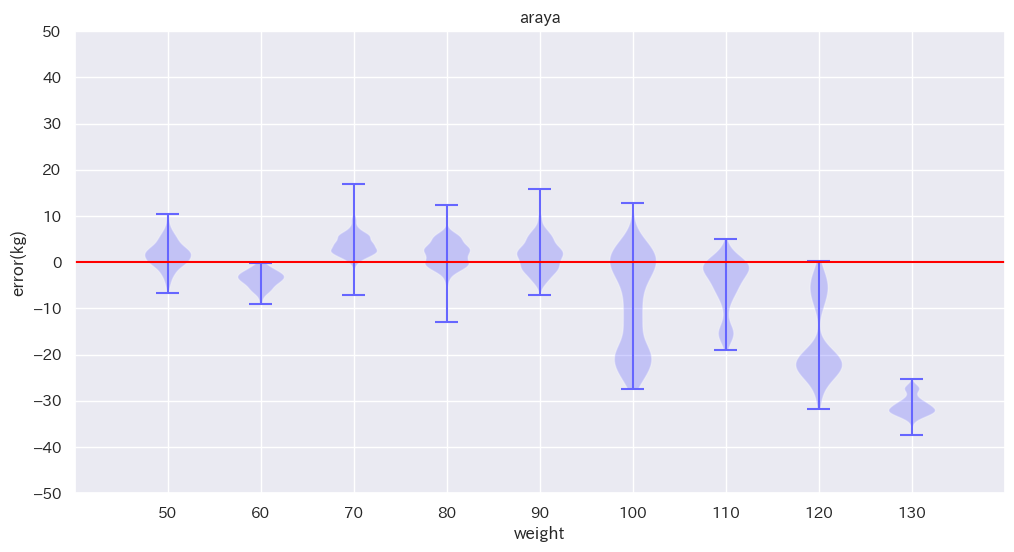

In [10]:
# バイオリンプロット
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.violinplot(data_list)
ax.set_xticks(xticks_list)
ax.set_xticklabels(xticks_label_list)
ax.set_xlabel("weight")
ax.set_yticks([-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50])
ax.set_ylabel("error(kg)")

ax.plot([0, 10], [0, 0], c="red")
ax.set_xlim([0, 10])
ax.set_ylim([-50, 50])

plt.title(target_model)

plt.show()
# plt.savefig('violinplot_weight.jpg')
# plt.clf()
# plt.close()


In [11]:
# 豚ID別
unique_key_df = target_df[["data_dir", "pig_id", "pig_weight"]].drop_duplicates("data_dir").sort_values("pig_weight").reset_index(drop=True)

data_list = []
xticks_list = []
xticks_label_list = []

for idx, row in unique_key_df.iterrows():
    data_list.append(target_df[(target_df["data_dir"] == row["data_dir"])]["error"].copy())
    xticks_list.append(idx + 1)
    xticks_label_list.append("{}_{}kg".format(row["pig_id"], row["pig_weight"]))


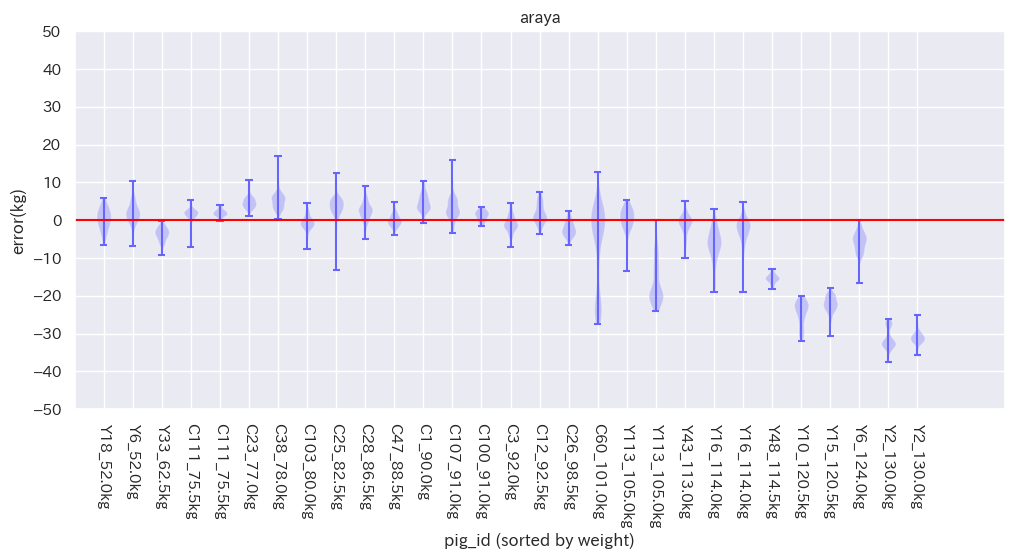

-6.413887000000003 5.898636000000003


In [12]:
# バイオリンプロット
plt.rcParams["figure.subplot.bottom"] = 0.25

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.violinplot(data_list)
ax.set_xticks(xticks_list)
ax.set_xticklabels(xticks_label_list, rotation=270)
ax.set_xlabel("pig_id (sorted by weight)")
ax.set_yticks([-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50])
ax.set_ylabel("error(kg)")

ax.plot([0, 32], [0, 0], c="red")
ax.set_xlim([0, 32])
ax.set_ylim([-50, 50])

plt.title(target_model)

plt.show()
# plt.savefig('violinplot_pig_id.jpg')
# plt.clf()
# plt.close()

print(data_list[0].min(), data_list[0].max())


In [16]:
error_th = 10


In [17]:
def run_for_csv(pig_id, csv_path, output_path, movie_path, eval_type):

    df = pd.read_csv(csv_path)
    df = df_filter(df, eval_type, error_th)
    save_histgram(df, output_path)
    # save_histgram_movie(df, movie_path)

    mean = df["pred"].mean()
    print(pig_id + "平均値:" + str(mean))

    rate = len(df[df["誤差区分"] == "<4%"]) / (len(df[df["誤差区分"] == "<4%"]) + len(df[df["誤差区分"] == ">=4%"]))
    min_value = df.loc[(df["誤差区分"] == "<4%") | (df["誤差区分"] == ">=4%"), "pred"].min()
    max_value = df.loc[(df["誤差区分"] == "<4%") | (df["誤差区分"] == ">=4%"), "pred"].max()

    return rate, min_value, max_value


In [18]:
result_csv_lines = [["pig_id", "pig_weight", "sre_rate", "sre_v2_rate", "araya_rate", "sre_pos_rate", "sre_min", "sre_max", "sre_v2_min", "sre_v2_max", "araya_min", "araya_max", "sre_pos_min", "sre_pos_max"]]

for target_dir in dir_list:
    if not os.path.isdir(os.path.join(base_data_dir, target_dir)) or target_dir.endswith("bokeh"):
        continue
    data_dir = os.path.join(base_data_dir, target_dir)
    pig_id = target_dir.split("_")[0]
    pig_weight = target_dir.split("_")[1]

    csv_path = os.path.join(data_dir, pig_id + "_sre.csv")
    output_path = os.path.join(data_dir, pig_id + "_sre.jpg")
    movie_path = os.path.join(data_dir, "graph_sre")
    if os.path.exists(csv_path):
        sre_rate, sre_min, sre_max = run_for_csv(pig_id, csv_path, output_path, movie_path, "sre")

    csv_path = os.path.join(data_dir, pig_id + "_sre_v2.csv")
    output_path = os.path.join(data_dir, pig_id + "_sre_v2.jpg")
    movie_path = os.path.join(data_dir, "graph_sre_v2")
    if os.path.exists(csv_path):
        sre_v2_rate, sre_v2_min, sre_v2_max = run_for_csv(pig_id, csv_path, output_path, movie_path, "sre")

    csv_path = os.path.join(data_dir, pig_id + "_araya.csv")
    output_path = os.path.join(data_dir, pig_id + "_araya.jpg")
    movie_path = os.path.join(data_dir, "graph_araya")
    if os.path.exists(csv_path):
        araya_rate, araya_min, araya_max = run_for_csv(pig_id, csv_path, output_path, movie_path, "araya")

    csv_path = os.path.join(data_dir, pig_id + "_sre_pos.csv")
    output_path = os.path.join(data_dir, pig_id + "_sre_pos.jpg")
    movie_path = os.path.join(data_dir, "graph_sre_pos")
    if os.path.exists(csv_path):
        sre_pos_rate, sre_pos_min, sre_pos_max = run_for_csv(pig_id, csv_path, output_path, movie_path, "sre")

    csv_line = [pig_id, pig_weight, str(sre_rate), str(sre_v2_rate), str(araya_rate), str(sre_pos_rate), str(sre_min), str(sre_max), str(sre_v2_min), str(sre_v2_max), str(araya_min), str(araya_max), str(sre_pos_min), str(sre_pos_max)]

    result_csv_lines.append(csv_line)

# with open(os.path.join(base_data_dir, str(error_th) + '_eval_result.csv'), 'w', newline='') as file_:
with open(os.path.join(base_data_dir, "{}_{}_eval_result.csv".format(target_model, error_th)), "w", newline="") as file_:

    writer = csv.writer(file_, lineterminator="\n")
    writer.writerows(result_csv_lines)


Y16平均値:111.87643051933699
Y16平均値:109.57657613812155
Y16平均値:105.87838634254145
Y16平均値:116.17574275690608
C23平均値:81.76082209426988
C23平均値:82.85654324953788
C23平均値:82.04002093900186
C23平均値:83.82387874306839
C111平均値:77.26988735825546
C111平均値:78.10223854828659
C111平均値:77.18976871962616
C111平均値:75.33799412772586
Y113平均値:104.90650893129771
Y113平均値:105.97642860305344
Y113平均値:104.89222554198474
Y113平均値:108.32549101526718
C26平均値:96.78934366666665
C26平均値:95.22908699145297
C26平均値:96.62443721367521
C26平均値:95.80150868376067
C47平均値:87.54672819883041
C47平均値:89.06067201754387
C47平均値:88.37318197660818
C47平均値:90.8902053859649
Y2平均値:98.03379898130844
Y2平均値:96.29729674766355
Y2平均値:98.97791917757012
Y2平均値:124.75629787850468
C111平均値:76.88618058241758
C111平均値:78.23210595604395
C111平均値:77.49944281318682
C111平均値:75.32368583516482
C28平均値:89.3801626111111
C28平均値:87.29516115151516
C28平均値:89.2611359090909
C28平均値:88.45674545959595
C3平均値:91.68980121637428
C3平均値:90.3841949005848
C3平均値:91.20285504678363
C3平均値:90.663410